In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_excel(r"C:\Users\User\Desktop\train.xlsx")
df_test = pd.read_excel(r"C:\Users\User\Desktop\test.xlsx")

df_train 


,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [13]:
df_train.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


Исходный график

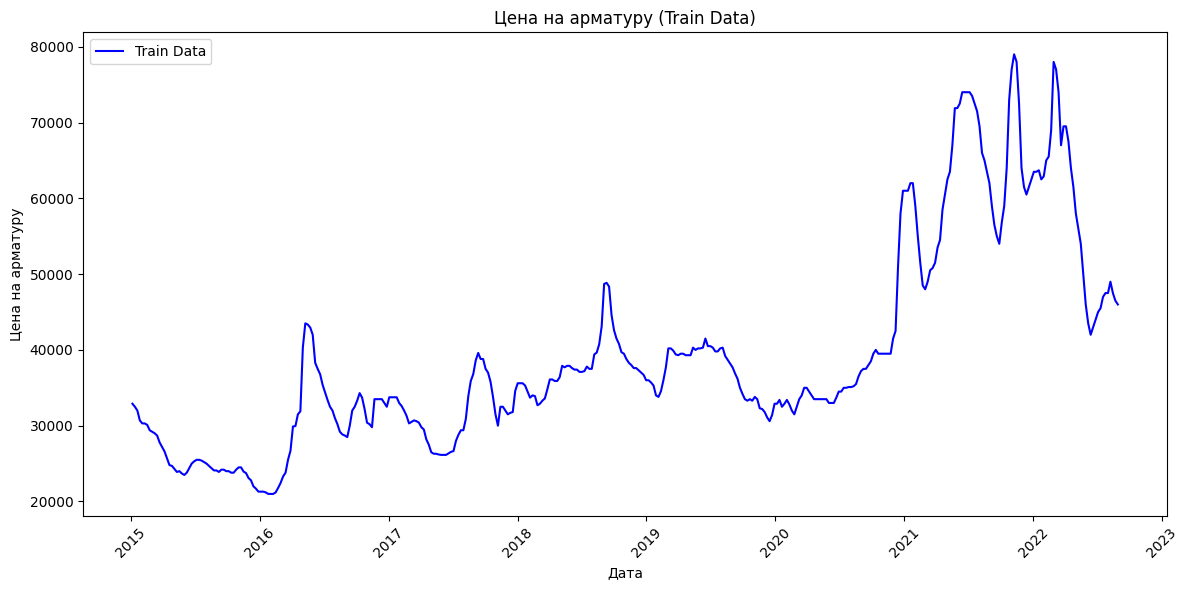

In [37]:
import matplotlib.pyplot as plt

# --- 1. Визуализация цен ---
plt.figure(figsize=(12, 6))
plt.plot(df_train['dt'], df_train['Цена на арматуру'], label='Train Data', color='blue')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Цена на арматуру (Train Data)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Разложение времянного ряда

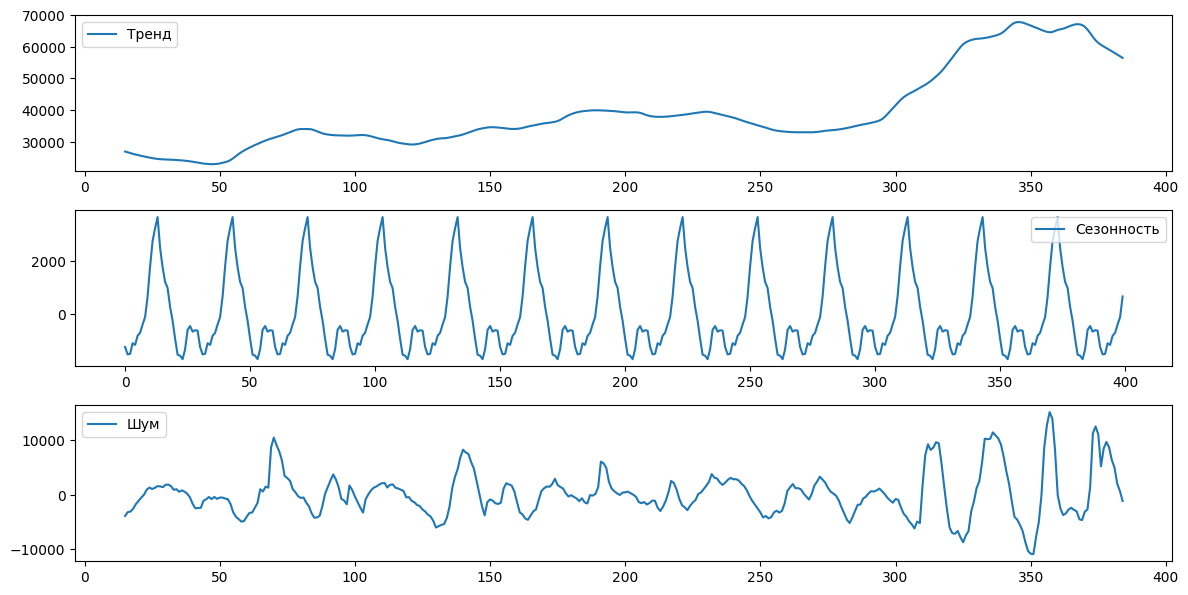

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Разложение временного ряда
decomposition = seasonal_decompose(df_train['Цена на арматуру'], model='additive', period=30)


# Визуализация компонентов
plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.plot(decomposition.trend, label='Тренд')
plt.legend()

plt.subplot(312)
plt.plot(decomposition.seasonal, label='Сезонность')
plt.legend()

plt.subplot(313)
plt.plot(decomposition.resid, label='Шум')
plt.legend()

plt.tight_layout()
plt.show()

Графики ACF и PACF

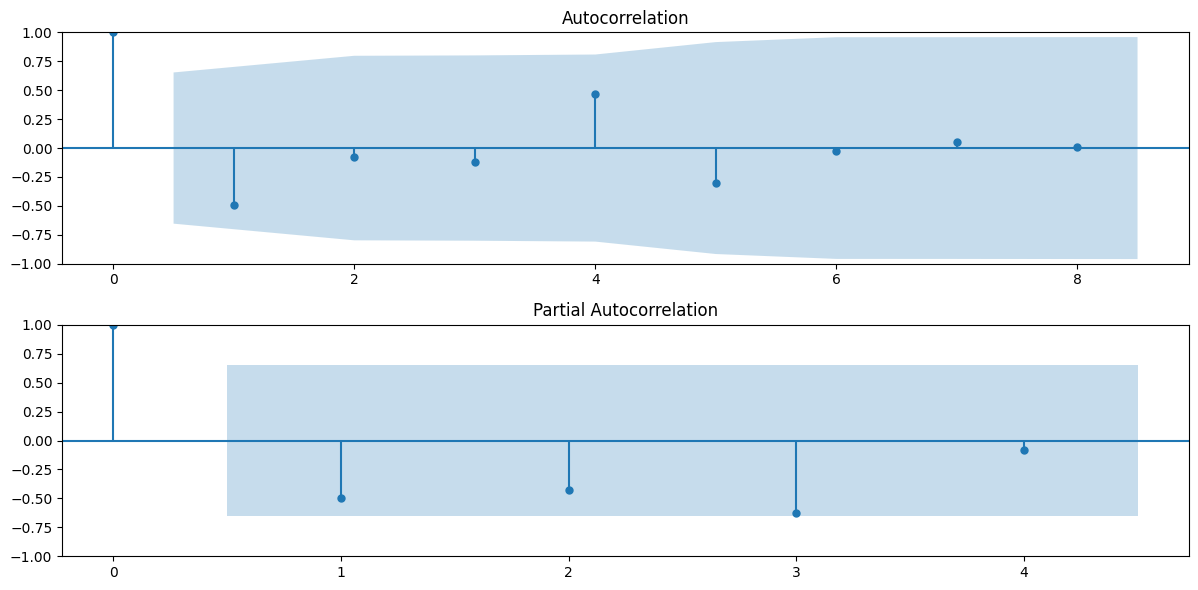

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data = [10, 12, 15, 13, 16, 18, 20, 19, 22, 24] 
series = pd.Series(data)
series_diff = series.diff().dropna()

# 2. Построение графиков ACF и PACF ДЛЯ ДИФФЕРЕНЦИРОВАННОГО РЯДА
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(series_diff, ax=ax1, lags=len(series_diff) - 1)
plot_pacf(series_diff, ax=ax2, lags=min(len(series_diff) // 2, len(series_diff) - 1), method='ywm')
plt.tight_layout()
plt.show()

Обучение модели Prophet

C:\Users\User\AppData\Local\Temp\ipykernel_2324\3214141579.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cap'], test_data['cap'] = cap, cap
C:\Users\User\AppData\Local\Temp\ipykernel_2324\3214141579.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cap'], test_data['cap'] = cap, cap
12:09:04 - cmdstanpy - INFO - Chain [1] start processing


Обучающая выборка: 300, Тестовая выборка: 100


12:09:04 - cmdstanpy - INFO - Chain [1] done processing


MSE: 532870135.19, MAE: 20339.99, MAPE: 32.34%


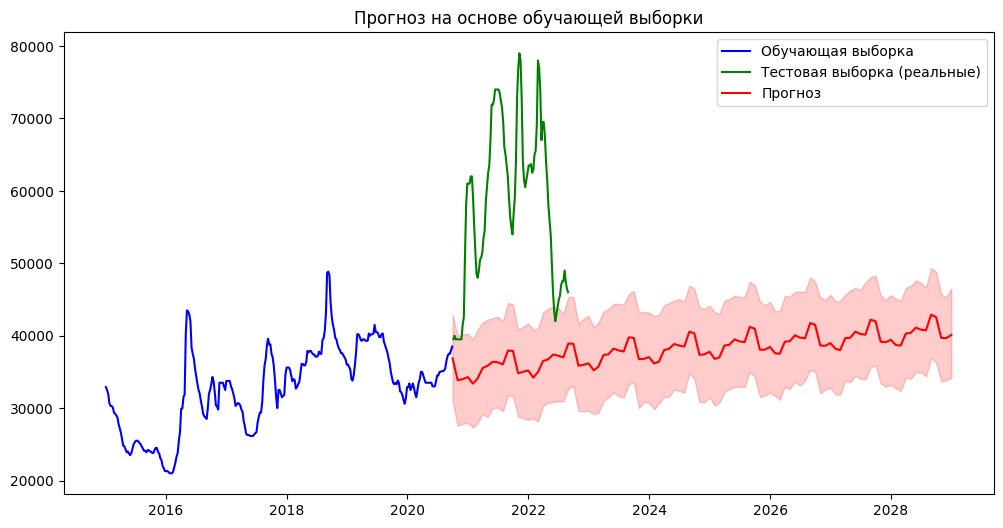

In [39]:
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 1. Разделение данных ---
train_size = int(len(data) * 0.75)
train_data, test_data = data[:train_size], data[train_size:]

print(f"Обучающая выборка: {len(train_data)}, Тестовая выборка: {len(test_data)}")

# --- 2. Настройка cap и модели Prophet ---
cap = train_data['y'].max() * 1.1
train_data['cap'], test_data['cap'] = cap, cap

model = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    seasonality_prior_scale=40,  # Увеличиваем для сезонности
    changepoint_prior_scale=0.01,  # Стабильный тренд
    changepoint_range=0.9
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=6)

# --- 3. Обучение и прогнозирование ---
model.fit(train_data)
future = model.make_future_dataframe(periods=len(test_data), freq='ME')  # 'ME' вместо 'M'
future['cap'] = cap
forecast = model.predict(future)

test_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test_data)).reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# --- 4. Оценка качества ---
mse = mean_squared_error(test_data['y'], test_forecast['yhat'])
mae = mean_absolute_error(test_data['y'], test_forecast['yhat'])
mape = (abs((test_data['y'] - test_forecast['yhat']) / test_data['y']).mean()) * 100

print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

# --- 5. Визуализация ---
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Обучающая выборка', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Тестовая выборка (реальные)', color='green')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Прогноз', color='red')
plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], color='red', alpha=0.2)
plt.legend()
plt.title("Прогноз на основе обучающей выборки")
plt.show()

11:18:02 - cmdstanpy - INFO - Chain [1] start processing


Установлен cap: 86900.00


11:18:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 260789891.95
Mean Absolute Error (MAE): 15654.30
Mean Absolute Percentage Error (MAPE): 36.09%


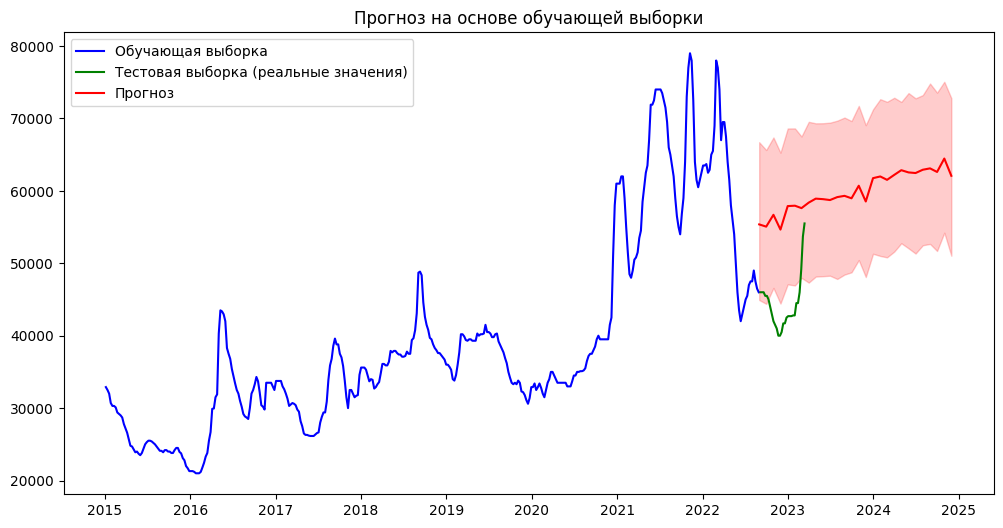

Прогноз сохранен в файл 'forecast_results.xlsx'


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 1. Загрузка данных ---
def load_data(train_path, test_path):
    """Загружает обучающие и тестовые данные."""
    train_data = pd.read_excel(train_path, parse_dates=['dt'])
    test_data = pd.read_excel(test_path, parse_dates=['dt'])
    train_data = train_data.rename(columns={'dt': 'ds', 'Цена на арматуру': 'y'})
    test_data = test_data.rename(columns={'dt': 'ds', 'Цена на арматуру': 'y'})
    return train_data, test_data

train_data, test_data = load_data(
    r"C:\Users\User\Desktop\train.xlsx",
    r"C:\Users\User\Desktop\test.xlsx"
)

# --- 2. Настройка параметра cap ---
cap = train_data['y'].max() * 1.1  # Максимальное значение + 10% буфера
print(f"Установлен cap: {cap:.2f}")

# Добавляем cap к обучающим и тестовым данным
train_data['cap'], test_data['cap'] = cap, cap

# --- 3. Настройка модели Prophet ---
def create_model():
    """Создает и настраивает модель Prophet."""
    model = Prophet(
        growth='logistic',
        yearly_seasonality=True,
        seasonality_prior_scale=40,  # Увеличиваем для учета сезонности
        changepoint_prior_scale=0.01,  # Уменьшаем для стабильного тренда
        changepoint_range=0.9
    )
    
    # Добавляем дополнительные сезонности
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=3)  # Квартальная сезонность
    
    return model

model = create_model()

# --- 4. Обучение модели Prophet ---
model.fit(train_data)

# --- 5. Прогнозирование на тестовой выборке ---
def make_forecast(model, test_data, periods, freq='ME'):
    """Делает прогноз для тестовых данных."""
    future = model.make_future_dataframe(periods=periods, freq=freq)
    future['cap'] = cap
    forecast = model.predict(future)
    test_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test_data))
    return test_forecast.reset_index(drop=True)

test_forecast = make_forecast(model, test_data, len(test_data))

# --- 6. Оценка качества модели ---
def evaluate_model(test_data, test_forecast):
    """Оценивает качество модели с использованием метрик MSE, MAE и MAPE."""
    mse = mean_squared_error(test_data['y'], test_forecast['yhat'])
    mae = mean_absolute_error(test_data['y'], test_forecast['yhat'])
    mape = np.mean(np.abs((test_data['y'] - test_forecast['yhat']) / test_data['y'])) * 100
    
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    return mse, mae, mape

evaluate_model(test_data, test_forecast)

# --- 7. Визуализация результатов ---
def plot_results(train_data, test_data, test_forecast):
    """Визуализирует исторические данные, реальные значения и прогноз."""
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['ds'], train_data['y'], label='Обучающая выборка', color='blue')
    plt.plot(test_data['ds'], test_data['y'], label='Тестовая выборка (реальные значения)', color='green')
    plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Прогноз', color='red')
    plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], color='red', alpha=0.2)
    plt.legend()
    plt.title("Прогноз на основе обучающей выборки")
    plt.show()

plot_results(train_data, test_data, test_forecast)

# --- 8. Сохранение прогнозов ---
def save_forecast(test_data, test_forecast, output_path):
    """Сохраняет прогнозы в файл."""
    test_data['Прогноз'] = test_forecast['yhat']
    test_data['Нижняя граница'] = test_forecast['yhat_lower']
    test_data['Верхняя граница'] = test_forecast['yhat_upper']
    test_data.to_excel(output_path, index=False)
    print(f"Прогноз сохранен в файл '{output_path}'")

save_forecast(test_data, test_forecast, "forecast_results.xlsx")